In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib notebook
import locale
from matplotlib.ticker import ScalarFormatter

In [2]:
file = 'data/spb-rentals-2020-feb'
df = pd.read_csv(file + '.csv', encoding='utf-16', delimiter='\t')
df.head()

,ID,Дата,Тип жилья,Тип дома,Год постройки,Этаж,Адрес,X,Y,Станция метро,"Расстояние до метро, м","Общая площадь, м","Площадь кухни, м","Жилая площадь, м","Аренда, руб./мес.","Ком. платежи, руб./мес.","Комиссия, %","Комиссия, руб.","Общий платеж, руб./мес",Описание
0,373307,04.02.2021,студия,Кирпичный,1975 г.п.,6/16 этаж,"Наличная ул., 51",59.951063,30.234309,Приморская,280,20.0,NaN,NaN,18000,2500.0,50,9000.0,20500,"\r\n Просторна, тёплая квартира..."
1,373306,04.02.2021,студия,Кирпичный,2011 г.п.,16/17 этаж,"Ленинский пр., 84к2",59.858804,30.199274,Ленинский пр.,4010,30.0,2.0,NaN,19000,2000.0,50,9500.0,21000,\r\n Отличная квартира-студия н...
2,373288,04.02.2021,студия,Кирпичный,,2/6 этаж,"Подольская ул., 44",59.913083,30.328014,Технологический и-т,620,16.0,NaN,NaN,20000,3000.0,15,3000.0,23000,\r\n Сдам на длительный срок кв...
3,373273,04.02.2021,студия,Кирп.Монолит,,13/24 этаж,"Пулковская ул., 6к2",59.839669,30.350828,Звездная,740,25.0,NaN,NaN,18000,2500.0,60,10800.0,20500,\r\n Сдается квартира-студия в ...
4,373268,04.02.2021,студия,Монолит,,11/14 этаж,"Ковалевская ул., 26к1",59.979444,30.510961,Ладожская,6580,26.0,6.0,NaN,16000,3500.0,60,9600.0,19500,\r\n Сдам квартиру студию в хор...


In [3]:
df_1 = df[(df['Аренда, руб./мес.'] <= 100000) & (df['Тип жилья'] == '1-комн. квартира')]
df_2 = df[(df['Аренда, руб./мес.'] <= 100000) & (df['Тип жилья'] == '2-комн. квартира')]

In [4]:
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371 # Earth radius
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [5]:
start_lat, start_lon = 59.9311, 30.3609

In [38]:
def new_df(df):
    locations = pd.DataFrame(data={
        'Lat' : df['X'],
        'Lon' : df['Y'],
        'Rent': df['Аренда, руб./мес.']
    })
    distances_km = []
    for row in locations.itertuples(index=False):
        distances_km.append(
           haversine_distance(start_lat, start_lon, row.Lat, row.Lon)
        )
    locations['DistanceFromCenter'] = distances_km
    locations = locations[['Rent', 'DistanceFromCenter']]
    locations = locations.sort_values(by='DistanceFromCenter', ascending=False)
    return locations

In [98]:
sns.set(rc={'axes.facecolor':'#242426'}) # graph facecolor
facecolor = '#242426'
font_color = '#ddd'
csfont = {'fontname':'Georgia'} # title font
hfont = {'fontname':'Calibri'} # main font
color_1 = '#cdf151'

In [97]:
def draw_chart(df, title, x_ticks, y_ticks):
    fig, ax = plt.subplots(facecolor=facecolor)
    fig.set_size_inches(10, 6)
    plt.grid(color=font_color, linestyle='-', linewidth=.5)
    sns.regplot('DistanceFromCenter', 'Rent', data=df, color=color_1)
    plt.subplots_adjust(wspace=0, top=0.85, bottom=0.15, left=0.12, right=0.93)

    ax.set_ylabel('Стоимость аренды, руб./мес.', color=font_color, fontsize=16, **hfont)
    ax.set_xlabel('Расстояние до центра, км', color=font_color, fontsize=16, **hfont)

    title = title
    ttl = ax.set_title(title, fontsize=18, pad=18, color=font_color, **csfont)
    ttl.set_position([.5, 1])

    plt.xticks(color=font_color, **hfont)
    plt.yticks(color=font_color, **hfont)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

    ax.spines['bottom'].set_color(font_color)
    ax.spines['top'].set_color(font_color)
    ax.spines['left'].set_color(font_color)
    ax.spines['right'].set_color(font_color)
    mpl.rcParams['axes.linewidth'] = .5
    
#     ax.set_ylim(1, 100_000)

    class MyScalarFormatter(ScalarFormatter):
        def __call__(self, x, pos=None):
            if len(self.locs) == 0:
                return ''
            else:
                xp = (x - self.offset) / (10. ** self.orderOfMagnitude)
                if abs(xp) < 1e-8:
                    xp = 0
                if self._useLocale:
                    s = locale.format_string(self.format, (xp,), grouping=True)
                else:
                    s = self.format % xp
                return self.fix_minus(s)

    sf = MyScalarFormatter(useLocale=True)
    locale._override_localeconv = {'thousands_sep': ' ', 'grouping': [3,0]}

    ax.yaxis.set_major_formatter(sf)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (<ipython-input-97-64586ed35e4d>, line 9)

<IPython.core.display.Javascript object>


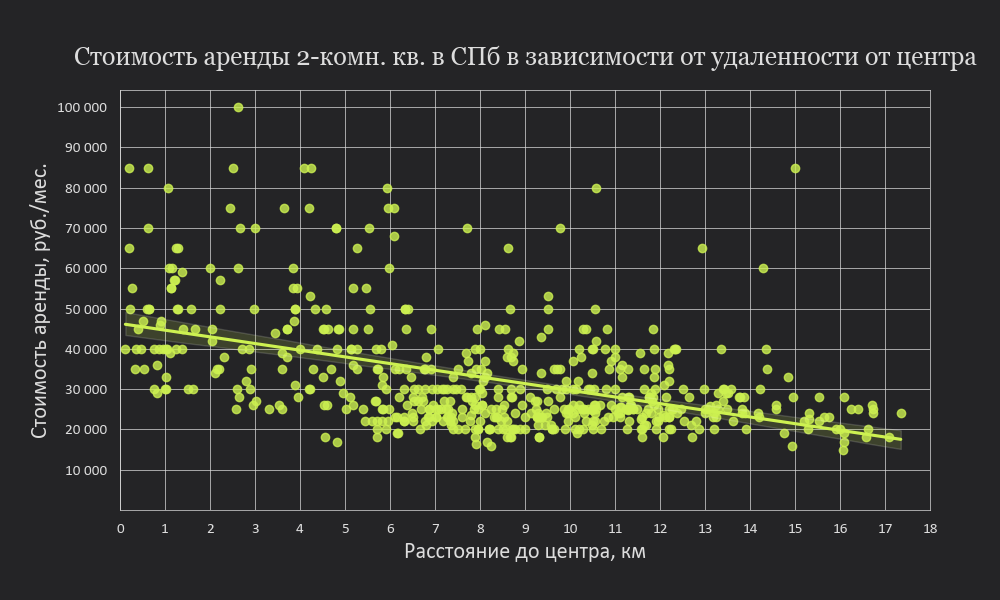

In [84]:
draw_chart(new_df(df_2), 
           'Стоимость аренды 2-комн. кв. в СПб в зависимости от удаленности от центра',
           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
           [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000])

In [85]:
filename = 'images/center-distance-2br'
plt.savefig(filename+'.png', facecolor=facecolor)

<IPython.core.display.Javascript object>


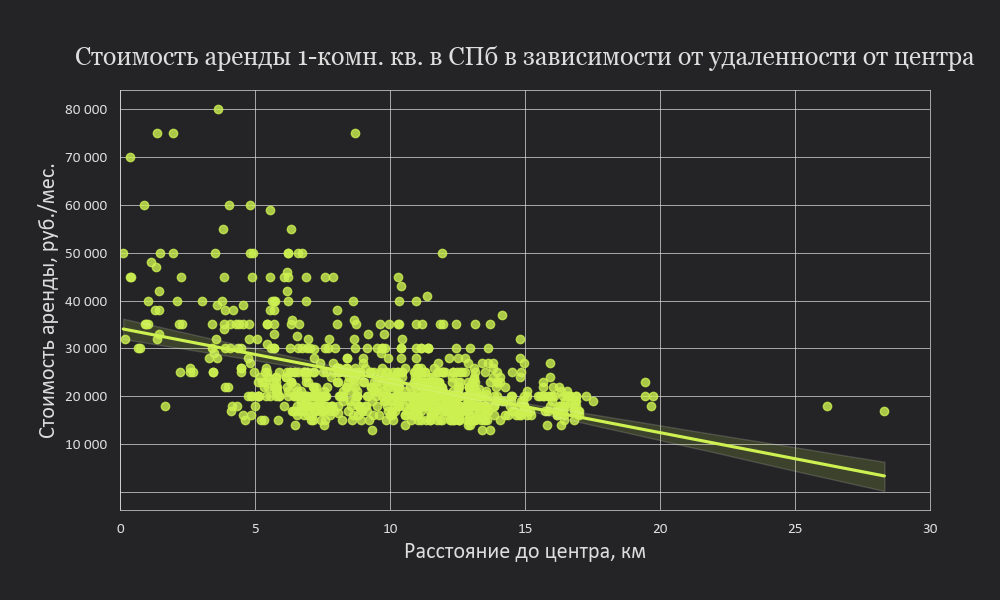

In [95]:
draw_chart(new_df(df_1), 
           'Стоимость аренды 1-комн. кв. в СПб в зависимости от удаленности от центра',
           [0, 5, 10, 15, 20, 25, 30],
           [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000])

In [96]:
filename = 'images/center-distance-1br'
plt.savefig(filename+'.png', facecolor=facecolor)